# Determining Ryzhenko-Bryzgalin Model Parameters
The __Ryzhenko-Bryzgalin (RB) model__ describes how the dissociation constant of an aqueous complex varies as a function of temperature and pressure. In this JupyterLab Notebook, I calculate the RB fitting parameters for a set of aqueous complexes by fitting the model to their dissociation constants, which were found experimentally for a suite of temperature and pressure conditions. The fitting procedure employs the `curve_fit` library from `scipy.optimize`.

## 1. Import libraries

In [2]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import thermofun as fun
import reaktoro as rkt

## 2. Initialize a thermodynamic database and engine to operate on that database

In [3]:
database = fun.Database('./hydrothermal-geochemistry-modeling/databases/Co_Cu_aq_speciation.json')
engine = fun.ThermoEngine(database)

RuntimeError: 
****************************************************************************************************************
*** Error: File reading error
*** Reason: Database file ./hydrothermal-geochemistry-modeling/databases/Co_Cu_aq_speciation.json not found!
*** Location: ...fun_1586453280702/work/ThermoFun/Database.cpp:279
****************************************************************************************************************



## 3. Define the Ryzhenko-Bryzgalin model

$$pK_{T,P} = pK_{298,1}\frac{298}{T} + \overline B_{T,P}(zz/a)$$
where $\overline B_{T,P}$ is defined as 
$$\overline B_{T,P} = \frac{pK_{T,P}^W - pK_{298,1}^W 298/T}{(zz/a)_W}$$
and $zz/a$ is defined as 
$$zz/a = A + \frac{B}{T}$$
$pK_{T,P}^W$, the opposite of the dissociation constant for water, is found for the following reaction: 
$$H_2O \leftrightarrow H^+ + OH^-$$
and can be determined using the equation: 
$$logK_{T,P}^W = a + \frac{b}{T} + \frac{c}{T^2} + \frac{d}{T^3} + (e + \frac{f}{T} + \frac{g} {T^2})log\rho$$
In this notebook, however, I've employed `ThermoFun` to calculate $pK_{T,P}^W$ using the method of Johnson and Norton (1991). 

In [3]:
def RB_model(TP, pK_298_1, A, B):
    T,P = TP # unzip temperature and pressure arrays
    
    # dissociation constant for water @ 298.15 K, 1 bar
    pKW_298_1 = -engine.thermoPropertiesReaction(298.15, 1e5, "H2O@ = H+ + OH-").log_equilibrium_constant.val
    
    # dissociation constant for water @ T, P
    pKW = np.zeros(len(T)) # initialize array of dissociation constants for water @ T, P
    for i,(temp,press) in enumerate(zip(T,P),0):
        pKW[i] = -engine.thermoPropertiesReaction(temp, press, "H2O@ = H+ + OH-").log_equilibrium_constant.val
        
    zz_a_W = 1.01707 # [unitless] (GEM-Selektor; Shvarov and Bastrakov, 1999)
    B_bar = (pKW - pKW_298_1*298/T)/zz_a_W # define B_bar term
    zz_a = A + B/T # define zz_a term
    
    return pK_298_1*298.15/T + B_bar*zz_a # outputs pK_diss for T, P

## 4. Set experimental temperature and pressure conditions 

In [4]:
T = np.array([200, 250, 300]) + 273.15 # [K]
# calculate pressure assuming saturated water vapor pressure
P = np.zeros(len(T)) + 1
# for i,temp in enumerate(T,0): 
#     P[i] = rkt.waterSaturatedPressureWagnerPruss(float(temp)).val/100000 # [bar] 
# P = np.array([25.4975, 59.464, 120.51])

## 5. Define $logK_{diss}$ (first generally, and then for each of the complexes considered)

In [5]:
class logK_diss: 
    def __init__(self,substance,value,error,OptimC):
        self.sub = substance
        self.val = value
        self.err = error
        self.OptimC = OptimC # parameters from OptimC
        
CoCl4 = logK_diss('CoCl4--', np.array([5.12, 6.49, 8.33]), np.array([0.12, 0.11, 0.12]))
CoCl3 = logK_diss('CoCl3-', np.array([3.72, 5.06, 6.44]), np.array([0.14, 0.15, 0.14]))
CoCl2 = logK_diss('CoCl2@', np.array([2.71, 3.63, 4.94]), np.array([0.14, 0.15, 0.15]))
CoCl = logK_diss('CoCl+', np.array([1.37, 1.82, 2.42]), np.array([0.19, 0.21, 0.19]))
logK = [CoCl4, CoCl3, CoCl2, CoCl]

## 6. Visually inspect the experimental data by plotting $pK_{diss}(T,P)$

<IPython.core.display.Javascript object>


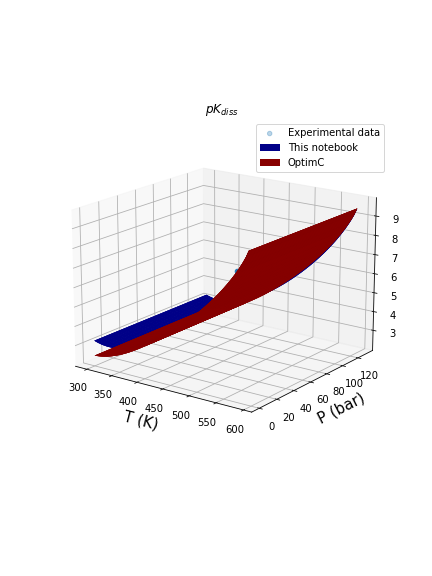

Text(0.5, 0.92, '$pK_{diss}$')

In [6]:
fig = plt.figure(figsize = (6,8))
ax = fig.gca(projection='3d')
%config InlineBackend.close_figures=False # keep figures open in pyplot
ax.scatter(T, P, CoCl4.val)
ax.set_xlabel('T (K)', fontsize=15)
ax.set_ylabel('P (bar)', fontsize=15)
ax.set_title('$pK_{diss}$')

## 7. Fit the RB model to the $pK_{diss}(T,P)$ data; output the fitting parameters

In [7]:
print(P)
popt, pcov = curve_fit(RB_model, (T,P), CoCl4.val, 0.5*CoCl4.err) # pK_298,1, A, B [unitless]
from IPython.display import display, Markdown
display(Markdown(
    rf"""
$pK_{{{(298,1)}}}$ is {popt[0]} <br>
A is {popt[1]} <br>
B is {popt[2]} <br>
    """))

[1. 1. 1.]


/Users/robertcollar/miniconda3/envs/geochem_model_env/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



$pK_{(298, 1)}$ is 3.212760615638665 <br>
A is 3.3520012474693965 <br>
B is -984.6116862092558 <br>
    

## 8. Visually inspect the results of the fit by plotting the model output against the experimental results

<IPython.core.display.Javascript object>


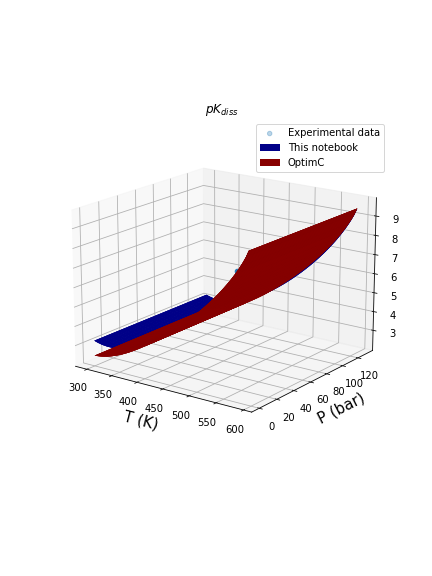

In [13]:
T_plot = np.arange(25,325,5) + 273.15
P_plot = [0]*len(T_plot)
for i,temp in enumerate(T_plot,0): 
    P_plot[i] = rkt.waterSaturatedPressureWagnerPruss(float(temp)).val/100000 # [bar] saturated water vapor pressure
P_plot = np.linspace(1,130,len(T_plot))
P_mesh,T_mesh = np.meshgrid(P_plot, T_plot)
y = RB_model((T_mesh.flatten(),P_mesh.flatten()), popt[0], popt[1], popt[2])
y_plot = np.split(y,len(T_plot))
y_mesh = np.stack(y_plot, axis=0)
ax1 = ax
ax1.plot_surface(T_mesh, P_mesh, y_mesh, color = 'b')
fig

## 9. Compare results to those based on OptimC

<IPython.core.display.Javascript object>


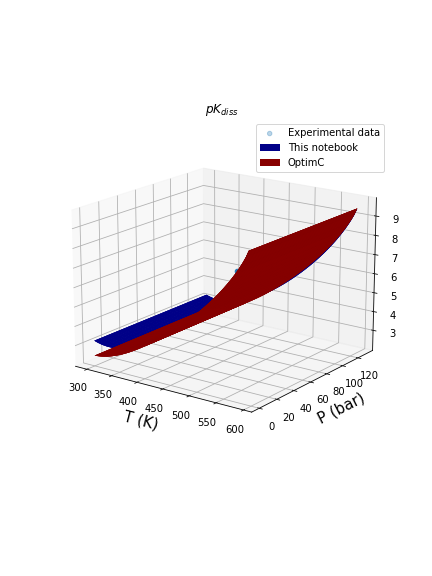

In [12]:
y2 = RB_model((T_mesh.flatten(),P_mesh.flatten()), 2.426, 2.899, -662.33) # input results manually from OptimC
y2_plot = np.split(y2,len(T_plot))
y2_mesh = np.stack(y2_plot, axis=0)
ax.plot_surface(T_mesh, P_mesh, y2_mesh, color = 'r')
ax.legend(['Experimental data','This notebook', 'OptimC'])
fig